# Feature Engineering

## Overview

1. Scikit learn transformers and pipelines  
  1a. Polynomial features
2. Numpy broadcasting for feature calculations  
3. Custom transformers  
  3a. Discretization (advanced: B-splines)  
  3b. Radial basis functions  
  3c. Random features  

## Prelude

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import auc as calc_auc, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

## Utility functions

In [ ]:
def make_moon_data(n_train, n_test, seed):
    n_samples = n_train + n_test
    X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.2, random_state=seed)

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_test = X[n_train:]
    y_test = y[n_train:]

    return {"train": (X_train, y_train), "test": (X_test, y_test)}


def get_limits(x):
    return min(x), max(x)


def plot_binary_data(X, y):
    plt.plot(X[y == 0, 0], X[y == 0, 1], "o", color="C0")
    plt.plot(X[y == 1, 0], X[y == 1, 1], "o", color="C1")


def plot_decision_boundary(model, xlim, ylim, ngrid=100):
    X = make_grid(xlim, ylim, ngrid)
    pred = model.predict(X)
    plt.plot(X[pred == 0, 0], X[pred == 0, 1], "o", color="C0", alpha=0.05)
    plt.plot(X[pred == 1, 0], X[pred == 1, 1], "o", color="C1", alpha=0.05)

    
def make_grid(xlim, ylim, ngrid):
    xgrid = np.linspace(*xlim, ngrid)
    ygrid = np.linspace(*ylim, ngrid)
    X, Y = np.meshgrid(xgrid, ygrid, indexing="ij")
    x = X.ravel()[:, None]
    y = Y.ravel()[:, None]
    return np.hstack((x, y))


def show_model(model, xlim, ylim, X, y):
    plt.figure(figsize=(8, 6))
    plot_decision_boundary(model, xlim, ylim)
    plot_binary_data(X, y)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [ ]:
lr_config = {
    "cv": 10,
    "max_iter": 1000,
}

data = make_moon_data(100, 100, 0)
X, y = data["train"]

xlim = get_limits(X[:, 0])
ylim = get_limits(X[:, 1])

## Scikit learn transformers and pipelines

### Transformers

Like estimators, but only operate on input (i.e. the matrix $X$). They transform a "rectangular" data set into another "rectangular" data set.

For example, the `PolynomialFeatures` transformer can transform:

$$
[x_1, x_2] \rightarrow [x_1, x_1^2, x_2, x_2^2, x1 \cdot x2]
$$

With `interaction_only = True`, we do not get higher order terms of only one variable:

$$
[x_1, x_2] \rightarrow [x_1, x_2, x_1 \cdot x_2]
$$

Key methods are `fit(X)` and `transform(X)`.

### Pipelines

If we stack $n \geq 1$ transformers, then we get another transformer.

If we put a classifier (for instance) at the end of that stack, then we have a composite function mapping from

$$
X \rightarrow X' \rightarrow X'' \rightarrow \ldots \rightarrow \hat{y}
$$

If the transformers have trainable parameters, then this is an important abstraction. It helps to make sure we don't "leak" information from the test data into our training data. An example of a trainable transformer is principal component analysis (PCA) for dimensionality reduction. By bundling all trainable parts of our model into a single composite model, it is easy to cross validate the entire pipeline.

To construct a pipeline:

```python
from sklearn.pipeline import Pipeline

my_pipe = Pipeline([
    ("step-1-label", Transformer1()),
    ("step-2-label", Transformer2()),
    ("classifier", Classifier()),
])
```

We can now fit the pipeline object as a single model:

```python
my_pipe.fit(X, y)
my_pipe.predict_proba(X_test)
```

In [ ]:
models = {
    "linear": LogisticRegressionCV(**lr_config),
    "interaction2": Pipeline([
        ("features", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "interaction3": Pipeline([
        ("features", PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "polynomial2": Pipeline([
        ("features", PolynomialFeatures(degree=2, include_bias=False)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "polynomial3": Pipeline([
        ("features", PolynomialFeatures(degree=3, include_bias=False)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "polynomial4": Pipeline([
        ("features", PolynomialFeatures(degree=4, include_bias=False)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
}

for name in models:
    models[name].fit(X, y)

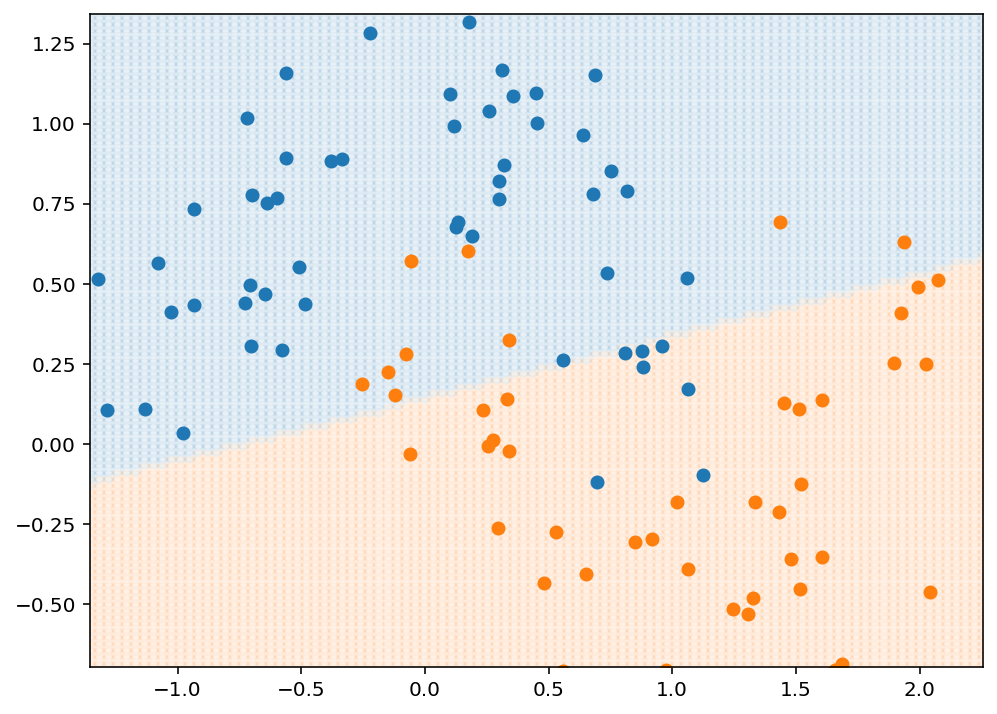

In [ ]:
show_model(models["linear"], xlim, ylim, *data["test"])

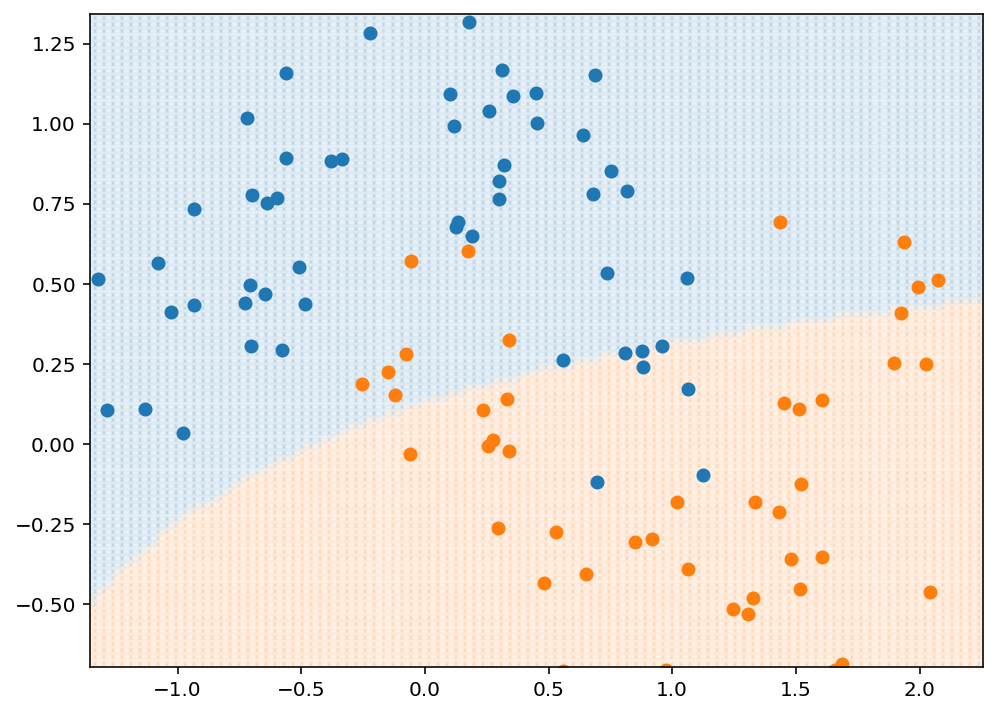

In [ ]:
show_model(models["interaction2"], xlim, ylim, *data["test"])

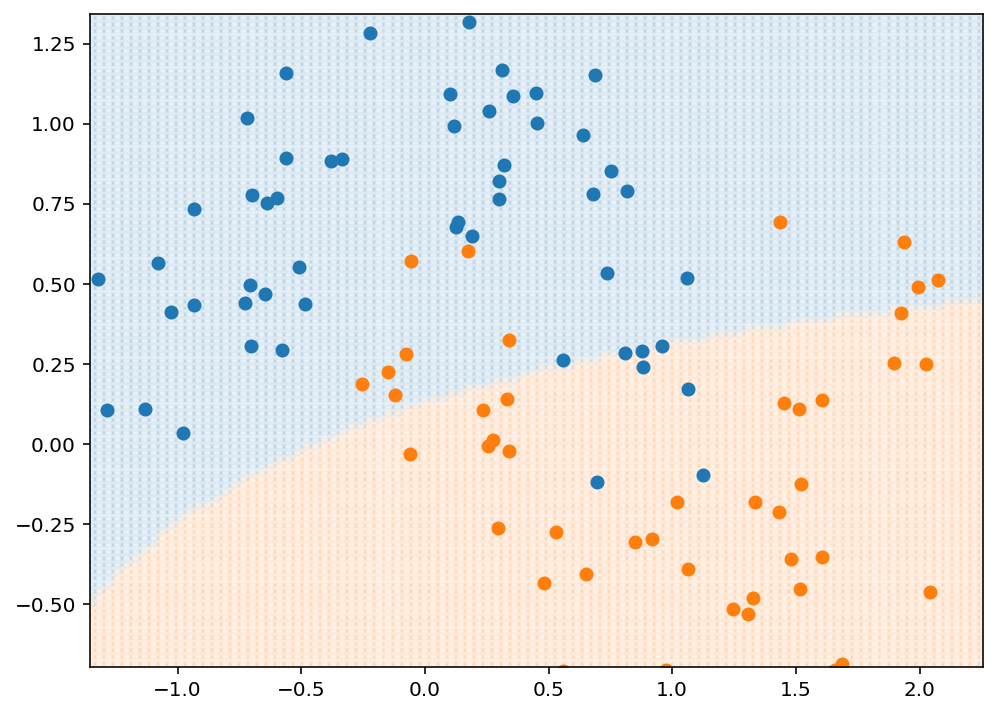

In [ ]:
show_model(models["interaction3"], xlim, ylim, *data["test"])

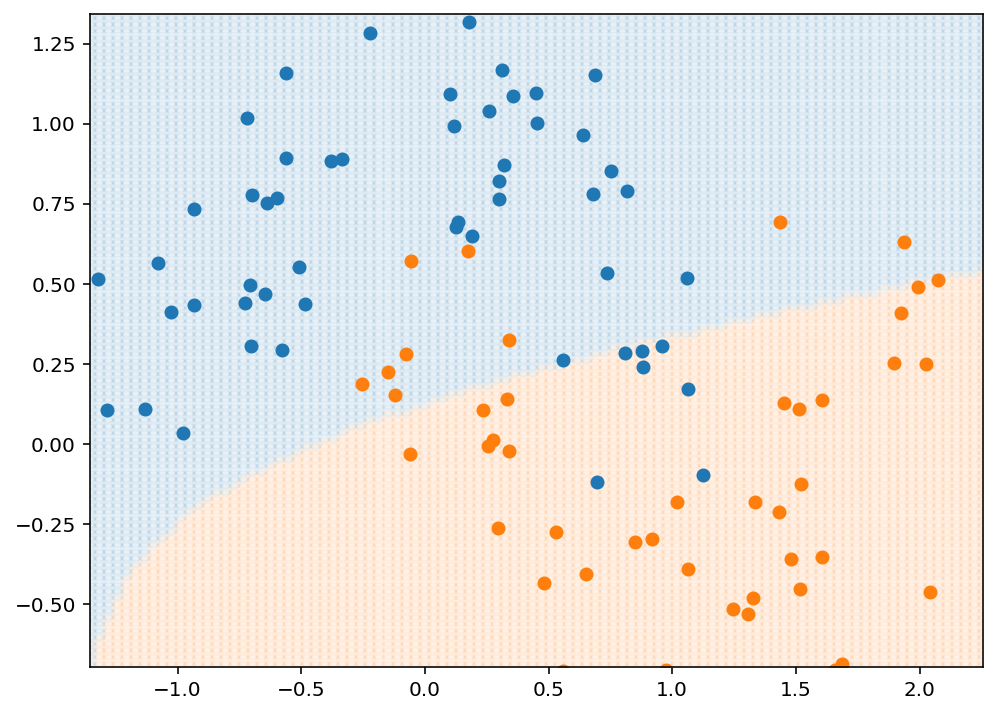

In [ ]:
show_model(models["polynomial2"], xlim, ylim, *data["test"])

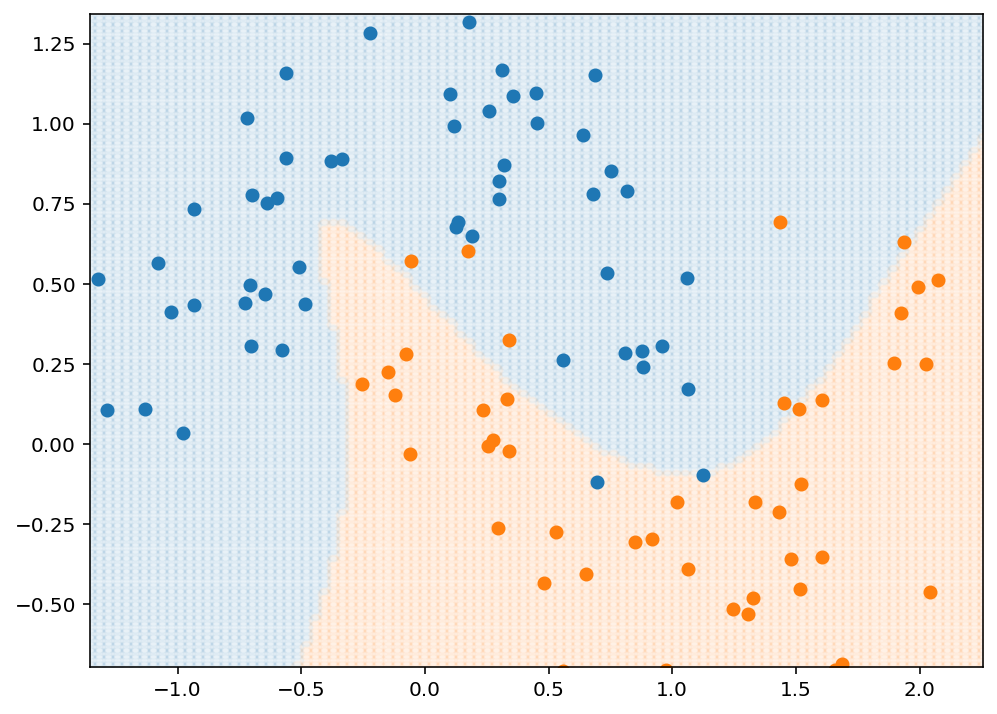

In [ ]:
show_model(models["polynomial3"], xlim, ylim, *data["test"])

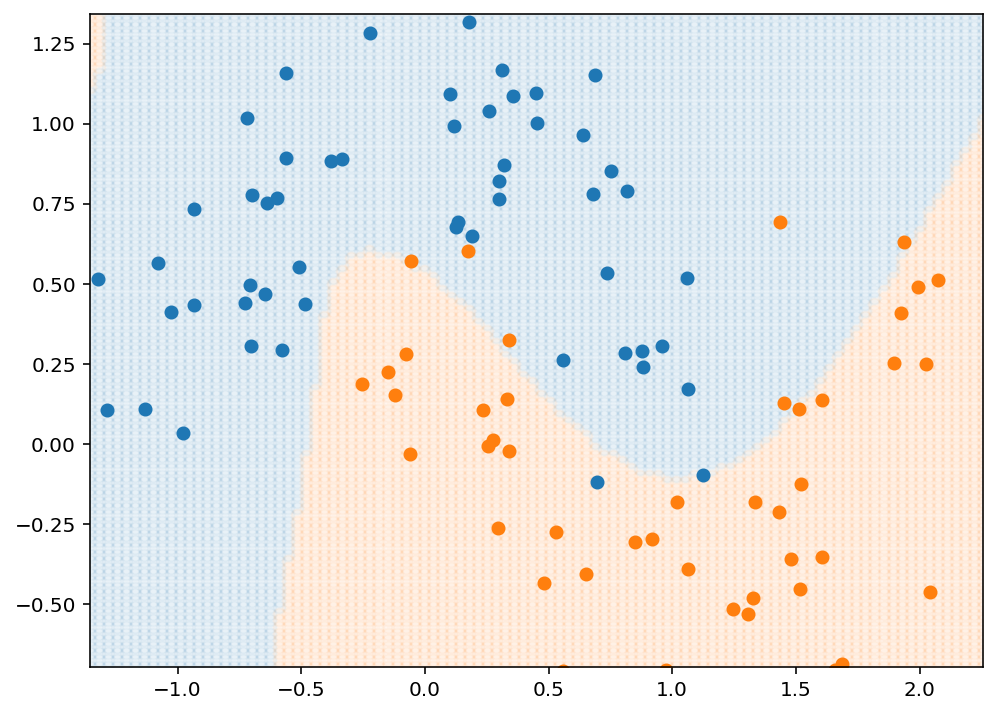

In [ ]:
show_model(models["polynomial4"], xlim, ylim, *data["test"])

## Numpy broadcasting

When is it valid to perform element-wise operations on two `numpy` arrays? This is governed by `numpy`'s "broadcasting" rules.

The rules are simple to state, but very powerful:

```
Two dimensions are compatible when
  1. they are equal, or
  2. one of them is 1
```

Whenever rule 2 applies, the rest of the array is reused for that part of the calculation.

Here's one of the simplest examples:

```python
import numpy as np

X = np.random.normal(size=(10, 3))
w = np.random.normal(size=(3,))

Z = X * w  # what does this do?

# we can also compute Z like this:

Z = np.empty((10, 3))

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = X[i, j] * w[j]  # we keep using w[j] for all values of i; it is "broadcast"
```

Here's another interesting example that solves a common use case. Suppose we have $n$ elements in the vector $x$ and $m$ elements in the vector $y$. How can we multiply each member of $x$ by each member of $y$?

Here is one way to do it:

```python
products = np.empty((n, m))

for i in range(len(x)):
    for j in range(len(y)):
        products[i, j] = x[i] * y[j]
```

Notice how we are reusing `x[i]` for each `j` and `y[j]` for each `i`. Does this broadcasting sound familiar?

Here's how we can do it in one line (and much faster):

```python
products = x[:, None] * y
```

The expression `x[:, None]` reshapes `x` to `(n, 1)`.

## Custom Transformers

They are straightforward to implement:

```python
from sklearn.base import BaseEstimator, TransformerMixin

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, config1, config2):
        self.config1 = config1
        self.config2 = config2
        
    def fit(self, X, y=None):
        self.param1_ = processing_step1(X)
        self.param2_ = processing_step2(X)
        return self
        
    def transform(self, X):
        Z = transform_step1(self.param1_, X)
        Z = transform_step2(self.param2_, Z)
        return Z
```

Rules of thumb:
1. Pass anything you know up front to the constructor.
2. Use `fit` to estimate things from data (e.g. the mean of each column)
3. Use `transform` to use what you learned in `fit` to modify your data

In [ ]:
class PercentileBuckets(BaseEstimator, TransformerMixin):
    def __init__(self, n, interaction=False):
        self.n = int(n)
        self.q = np.linspace(0, 1, self.n + 1)
        self.interaction = interaction
        
    def fit(self, X, y=None):
        ncol = X.shape[1]
        self.breaks_ = {}
        
        for i in range(ncol):
            self.breaks_[i] = np.quantile(X[:, i], self.q)
            
        return self
    
    def transform(self, X):
        chunks = []
        eye = np.eye(self.n)

        for i in sorted(self.breaks_):
            b = self.breaks_[i]
            x = np.clip(X[:, i], b[0], b[-1])
            x = x[:, None] >= b[1:-1]
            x = np.sum(x, axis=1)
            x = eye[x]
            chunks.append(x)
            
        if self.interaction:
            X, *rest = chunks
            for Y in rest:
                X = X[:, :, None] * Y[:, None, :]
                X = X.reshape((len(X), -1))
        else:
            X = np.hstack(chunks)

        return X
    
class RandomRBF(BaseEstimator, TransformerMixin):
    def __init__(self, n, seed=0):
        self.n = int(n)
        self.rng = random.Random(seed)
        
    def fit(self, X, y=None):
        self.centers_ = np.array(self.rng.sample(list(X), self.n))
        return self
    
    def transform(self, X):
        diff = X[:, None, :] - self.centers_[None, :, :]
        sq_dist = np.sum(diff**2, axis=-1)
        return np.exp(-0.5 * sq_dist)
    
class RandomReLU(BaseEstimator, TransformerMixin):
    def __init__(self, n, seed=0):
        self.n = int(n)
        self.rng = np.random.RandomState(seed)
        
    def fit(self, X, y=None):
        d = X.shape[1]
        self.weights_ = self.rng.normal(scale=1/self.n, size=(d, self.n))
        return self
    
    def transform(self, X):
        H = X @ self.weights_
        return np.clip(H, 0, None)

In [ ]:
models2 = {
    "discretized": Pipeline([
        ("features", PercentileBuckets(10)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "discretized2": Pipeline([
        ("features", PercentileBuckets(10, interaction=True)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "rbf": Pipeline([
        ("features", RandomRBF(10)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
    "relu": Pipeline([
        ("features", RandomReLU(100)),
        ("classifier", LogisticRegressionCV(**lr_config)),
    ]),
}

for name in models2:
    models2[name].fit(X, y)

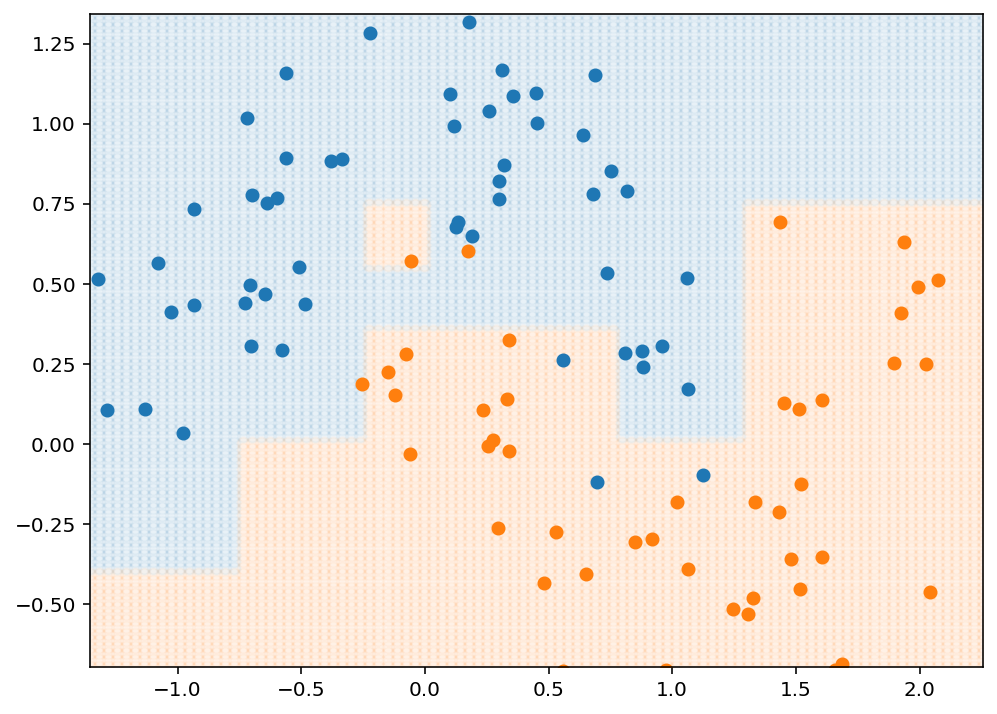

In [ ]:
show_model(models2["discretized"], xlim, ylim, *data["test"])

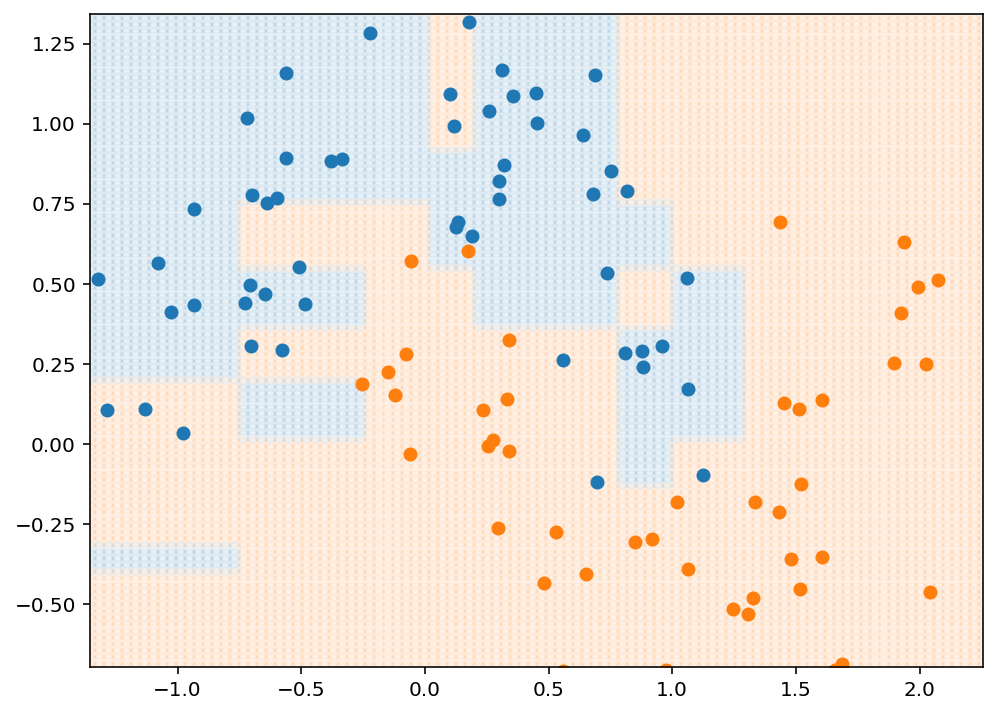

In [ ]:
show_model(models2["discretized2"], xlim, ylim, *data["test"])

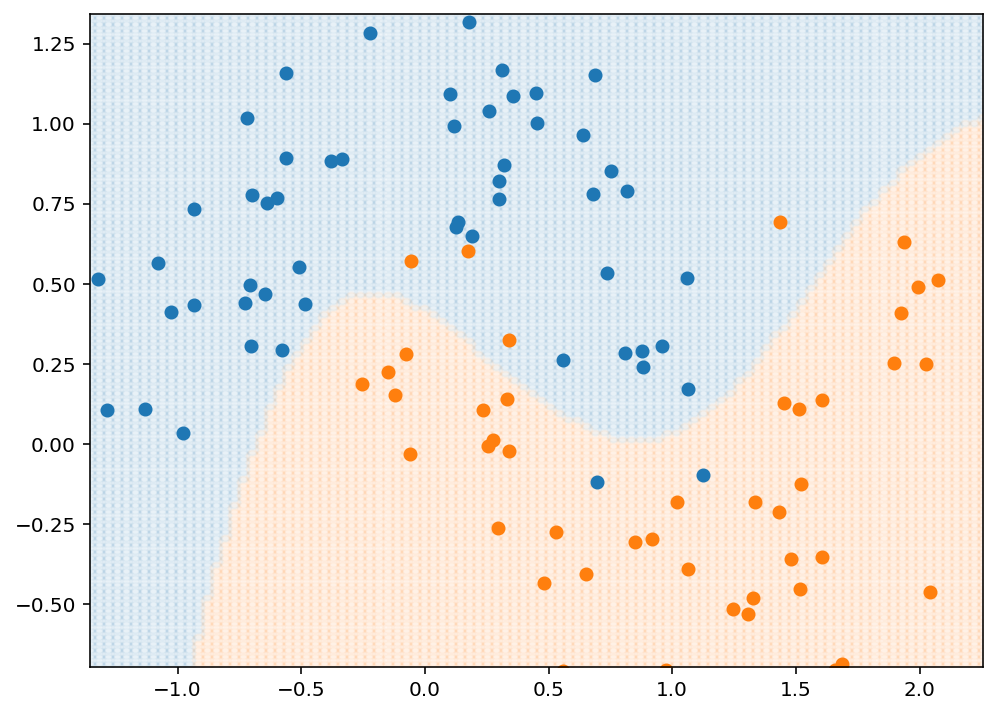

In [ ]:
show_model(models2["rbf"], xlim, ylim, *data["test"])

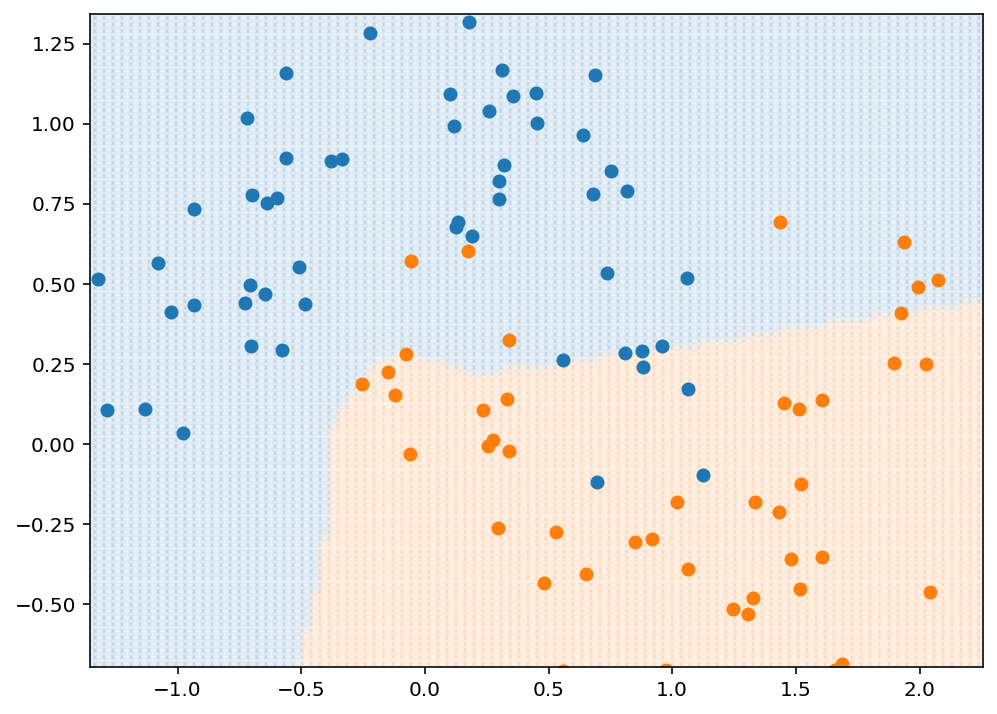

In [ ]:
show_model(models2["relu"], xlim, ylim, *data["test"])

In [ ]:
def evaluate_models(models, X, y):
    rows = []
    
    for name in models:
        proba = models[name].predict_proba(X)[:, 1]
        
        fpr, tpr, _ = roc_curve(y, proba)
        auc = calc_auc(fpr, tpr)
        
        rows.append({
            "model": name,
            "auc": auc,
        })
        
    return pd.DataFrame(rows)

In [ ]:
all_models = {**models, **models2}
evaluate_models(all_models, *data["test"]).sort_values("auc", ascending=False).round(3)

,model,auc
8,rbf,0.988
6,discretized,0.984
5,polynomial4,0.970
4,polynomial3,0.967
9,relu,0.949
7,discretized2,0.949
0,linear,0.945
3,polynomial2,0.934
1,interaction2,0.934
2,interaction3,0.934
